In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import shap
import torch
from matplotlib.colors import LinearSegmentedColormap, Normalize

from src.DRL.qnetwork import QNetwork
from src.utils import set_size_and_get_figsize
from src.XAI.concept import Concept
from src.XAI.concepts import concept_instances

In [3]:
# SHAP colormap
colors = [(30/255, 136/255, 229/255), (1, 1, 1), (255/255, 15/255, 88/255)]
cmap_name = 'blue_white_red'
blue_white_red = LinearSegmentedColormap.from_list(cmap_name, colors)
plt.register_cmap(cmap = blue_white_red)

The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.


In [4]:
class_names = ['NOOP', 'LEFT', 'RIGHT', 'JUMP', 'DODGE']
model_path = QNetwork.find_newest_model()
model_path = "runs/20240317-112025/model_10000000.pt"
model = QNetwork(model_path=model_path)

Loaded model: 20240317-112025-10000000


In [5]:
env_steps = Concept.load_concept_data()
concept = concept_instances['Random continuous']
concept.prepare_data(env_steps)
observations = concept.train_obs

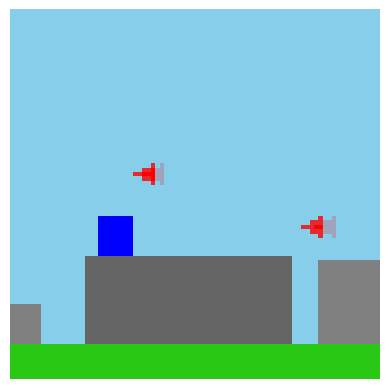

In [6]:
example_idx = 0
example_obs_np = observations[example_idx]
plt.imshow(example_obs_np)
plt.axis('off')
plt.show()

In [7]:
example_obs = torch.tensor([example_obs_np], dtype=torch.float32)
example_obs.requires_grad = True

# Compute the Q-values for the observation
q_values = model(example_obs)

num_actions = q_values.shape[1]

# Compute gradient for each action's Q-value
grads_per_action = []
for i in range(num_actions):
    model.zero_grad()
    # Select Q-value for the current action
    q_value = q_values[0, i]
    # Backpropagate the selected Q-value
    q_value.backward(retain_graph=True if i < num_actions - 1 else False)
    grads_per_action.append(example_obs.grad.clone())
    example_obs.grad.data.zero_()

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)


In [8]:
def plot_pixel_attributions(original_image, pixel_attributions, value_name='Gradient value', save_name='example'):
    # Ensure the pixel attributions are squeezed and summed correctly
    pixel_attributions = [attr.squeeze().mean(axis=-1) for attr in pixel_attributions]

    # Calculate the maximum absolute value for symmetric color scaling
    max_abs = max(abs(attr).max() for attr in pixel_attributions)

    # Setup for normalization and colormap
    norm = Normalize(vmin=-max_abs, vmax=max_abs)
    cmap = plt.set_cmap(cmap_name)

    fig, axes = plt.subplots(1, len(pixel_attributions) + 1, figsize=set_size_and_get_figsize(0.5))

    # Plotting the original image
    axes[0].imshow(original_image)
    axes[0].axis('off')

    # Plotting the pixel attribution images for each action
    for i, attr in enumerate(pixel_attributions):
        im = axes[i + 1].imshow(attr, cmap=cmap, norm=norm)
        axes[i + 1].set_title(class_names[i])
        axes[i + 1].axis('off')

    # Adjust subplot layout and add colorbar
    fig.subplots_adjust(bottom=0.25)
    cbar_ax = fig.add_axes([0.125, 0.4, 0.78, 0.03])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    cbar.outline.set_visible(False)
    cbar.set_label(value_name)

    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.savefig(f'figures/pixel attribution/{save_name}.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

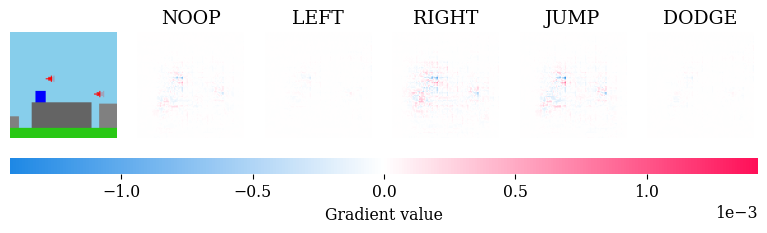

In [9]:
plot_pixel_attributions(example_obs_np, grads_per_action, value_name='Gradient value', save_name=f'gradients_{example_idx}')

In [10]:
background_data = torch.tensor(observations[:20000], dtype=torch.float32)
target_observation = torch.tensor([observations[example_idx]], dtype=torch.float32)
explainer = shap.DeepExplainer(model, background_data)

# Generate SHAP values for the target observation
shap_values = explainer.shap_values(target_observation)
# Visualize the SHAP values for the target observation
target_observation = target_observation.numpy().astype(int)

unrecognized nn.Module: Flatten


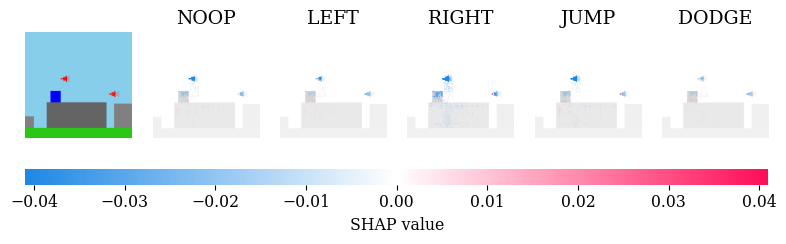

In [11]:
width, height = set_size_and_get_figsize(0.5)
shap.image_plot(shap_values, target_observation, class_names, width=width)